Connect to google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Change directory

In [2]:
cd /content/drive/My\ Drive/CSE_538

/content/drive/My Drive/CSE_538


Dataset statistic analysis

In [0]:
import pandas as pd

business_data = pd.read_json('businesses.json')
menu_data = pd.read_json('menus.json')
review_data = pd.read_json('reviews.json')

In [0]:
menu_data.describe()

,price,description,restaurant_id,name
count,30942,30942,30942,30942
unique,985,15221,419,23544
top,,,patina-restaurant-los-angeles-2,Cappuccino
freq,3410,13708,919,67


In [0]:
review_data.describe()

,review_rating
count,250091.000000
mean,4.103914
std,1.088979
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


In [0]:
business_data.describe()

,eat24_url,rating,distance,review_count,phone,menu_date_updated,reservation_url
count,0.0,419.000000,0.0,419.000000,4.180000e+02,4.190000e+02,0.0
mean,NaN,4.223150,NaN,604.479714,2.623882e+09,1.474037e+09,NaN
std,NaN,0.306959,NaN,776.897668,7.728270e+08,3.658953e+06,NaN
min,NaN,3.500000,NaN,16.000000,2.132104e+09,1.413186e+09,NaN
25%,NaN,4.000000,NaN,149.000000,2.135367e+09,1.472696e+09,NaN
50%,NaN,4.000000,NaN,332.000000,2.137475e+09,1.472872e+09,NaN
75%,NaN,4.500000,NaN,790.000000,3.234660e+09,1.475657e+09,NaN
max,NaN,5.000000,NaN,7322.000000,8.558640e+09,1.478471e+09,NaN


Installation

In [0]:
!pip install pytorch_pretrained_bert
!pip install tools
!pip install fuzzywuzzy

In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **Named entity recognition: Extracting menu items from review text**

Takes ~6 hours, you can directly load the quadruples.csv file present in the folder. The file is a result of this code.

In [0]:
import json
import re, string, timeit
import nltk
import time

import sys
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


def look_for_menu_item(menu, text):
    if len(text) <= 5:
        return
    translator=str.maketrans('','',string.punctuation)
    found_items = set()
    ltext = text.lower()
    ltext = (text.rstrip()).translate(translator)
    # exact matching
    for menu_item in menu:
        lmenu_item = menu_item.lower()
        if lmenu_item in ltext:
            yield menu_item, text
            found_items.add(menu_item)

    # if we already found more than two items let's stop searching
    if len(found_items) > 2:
        return

    # partial matching
    rest_items = [i for i in menu if i not in found_items]
    ext1 = process.extract(ltext, rest_items, scorer=fuzz.partial_ratio, limit=5)
    ext2 = process.extract(ltext, rest_items, scorer=fuzz.token_set_ratio, limit=5)

    ext1 = set(map(lambda x: x[0], filter(lambda x: x[1] > 80, ext1)))
    ext2 = set(map(lambda x: x[0], filter(lambda x: x[1] > 40, ext2)))

    ext = ext1.intersection(ext2)

    for menu_item in ext:
        yield menu_item, text


def produce_triples(reviews_file, menus_file, review_filter=None, restaurant_filter=None, verbose=False):
    if verbose:
        print("Loading datasets...", end="")
    with open(reviews_file, 'r') as f:
        reviews = json.load(f)
        if review_filter is not None:
            reviews = list(filter(review_filter, reviews))

    with open(menus_file, 'r') as f:
        menus = json.load(f)

    menus_by_restaurant = dict()
    restaurants = set()
    for m in menus:
        rid = m['restaurant_id']
        restaurants.add(rid)
        menus_by_restaurant.setdefault(rid, set())
        menus_by_restaurant[rid].add(m['name'])

    if restaurant_filter is not None:
        restaurants = set(filter(restaurant_filter, restaurants))

    if verbose:
        print("Done")
        print("Will begin analyzing reviews...")
    translator=str.maketrans('','',string.punctuation)
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    reviews = list(filter(lambda r: r['restaurant_id'] in restaurants, reviews))
    count = 0.0
    n_reviews = len(reviews)
    #sys.stderr.write("0.0")
    for review in reviews:
        count += 1
        #sys.stderr.write("\r{}".format(count / n_reviews))
        rtext = (review['review_text'].rstrip()).translate(translator)
        rid = review['restaurant_id']
        rating = review['review_rating']
        menu = menus_by_restaurant[rid]
        for sent in sent_tokenizer.tokenize(rtext):
            for menu_item, text in look_for_menu_item(menu, sent):
                yield rid, menu_item, text, rating
    #sys.stderr.write("\r1.0\n")


def main():
    reviews_file = "reviews.json"
    menus_file = "menus.json"
    
    produce_triples(reviews_file, menus_file)

    f = open('quadruples.csv', 'w')
    f.write('restaurant_id,menu_item,text,rating,\n')
    count = 0
    print("Working on it...Please wait...")
    #start = time.time()
    for restaurant, menu_item, review_text, rating in produce_triples(reviews_file, menus_file):
        f.write('{},{},{},{},\n'.format(restaurant, menu_item, review_text, rating))
        count += 1
    f.close()

if __name__ == '__main__':
    main()

Feature engineering and classifier models




Load all the libraries required

In [0]:
#nltk.download('wordnet')
%matplotlib inline
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper,
                          BasicTicker, ColorBar,DataRange1d, PanTool, Range1d, WheelZoomTool, BoxSelectTool)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.resources import INLINE
from collections import defaultdict
from keras import layers, models, optimizers
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from matplotlib.colors import ListedColormap
from nltk import pos_tag, pos_tag_sents
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.classify import ClassifierI
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import svm
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
from statistics import mode
import bokeh.io
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pandas, xgboost, numpy, textblob, string
import pickle
import random
import re
import seaborn as sns
import tensorflow as tf
from sklearn import calibration

Using TensorFlow backend.


Load the file generated after performing named entity recognition

In [0]:
yelp_reviews = pd.read_csv('quadruples.csv')

In [0]:
yelp_reviews.head(2)

,restaurant_id,menu_item,text,rating
0,submerge-sandwich-los-angeles,Lemon Herb Chicken Sandwich,The lemon herb chicken sandwich What is in it...,5
1,submerge-sandwich-los-angeles,Tuna Sandwich,Such a great little gem Was in LA on a busine...,5


labelling data

In [0]:
labels = []
for i in range(len(pd.Series.to_list(yelp_reviews['rating']))):
  if yelp_reviews['rating'][i] < 3:
    labels.append(0)
  else:
    labels.append(1)

In [0]:
yelp_reviews['labels'] = labels

In [0]:
df = yelp_reviews[['text','labels']]

splitting to test and train set

In [0]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['labels'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

extreacting count vector features

In [0]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [0]:
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


extracting the three tf-idf features

In [0]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100)
tfidf_vect.fit(df['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=100)
tfidf_vect_ngram.fit(df['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=100)
tfidf_vect_ngram_chars.fit(df['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

Optional section, just for test purpose

In [0]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

POS tagging, Optional section, just for test purpose

In [0]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [0]:
# Extereme Gradient Boosting
def train_xgboost(xtrain_count, train_y, xvalid_count):
  clf = xgboost.XGBClassifier()
  clf = clf.fit(xtrain_count.tocsc(), train_y)
  predictions = clf.predict(xvalid_count.tocsc())
  accuracy = metrics.accuracy_score(predictions, valid_y)
  f1 = metrics.f1_score(predictions,valid_y,labels=np.unique(valid_y))
  if (1 in predictions) and (0 in predictions):
    roc_score = metrics.roc_auc_score(predictions,valid_y)
  else:
    roc_score = None
  mean_sq_error = metrics.mean_squared_error(predictions,valid_y)
  mean_abs_error = metrics.mean_absolute_error(predictions,valid_y)
  return accuracy, f1, roc_score, mean_sq_error, mean_abs_error

In [0]:
# Extereme Gradient Boosting on Count Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_xgboost(xtrain_count, train_y, xvalid_count)
print ("count vector accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_xgboost(xtrain_tfidf, train_y, xvalid_tfidf)
print ("word level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# Extereme Gradient Boosting on Ngram Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_xgboost(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("ngram level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_xgboost(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("char level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

count vector accuracy: 0.9416599609150477 f1-score: 0.9696316907518775 roc_score: 0.9099363777149804 mean square error: 0.05834003908495229 mean absolute error: 0.05834003908495229
word level accuracy: 0.9349925278767675 f1-score: 0.9663212435233162 roc_score: 0.9286239331015451 mean square error: 0.06500747212323256 mean absolute error: 0.06500747212323256
ngram level accuracy: 0.9329233245200598 f1-score: 0.9652926481084939 roc_score: 0.8831369167385263 mean square error: 0.06707667547994023 mean absolute error: 0.06707667547994023
char level accuracy: 0.9332107138751581 f1-score: 0.9654310703873387 roc_score: 0.8512820512820511 mean square error: 0.06678928612484193 mean absolute error: 0.06678928612484193


In [0]:
# Random forest
def train_random_forest(xtrain_count, train_y, xvalid_count):
  clf = ensemble.RandomForestClassifier()
  clf = clf.fit(xtrain_count, train_y)
  predictions = clf.predict(xvalid_count)
  accuracy = metrics.accuracy_score(predictions, valid_y)
  f1 = metrics.f1_score(predictions,valid_y,labels=np.unique(valid_y))
  if (1 in predictions) and (0 in predictions):
    roc_score = metrics.roc_auc_score(predictions,valid_y)
  else:
    roc_score = None
  mean_sq_error = metrics.mean_squared_error(predictions,valid_y)
  mean_abs_error = metrics.mean_absolute_error(predictions,valid_y)
  return accuracy, f1, roc_score, mean_sq_error, mean_abs_error

In [0]:
# random_forest on Count Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_random_forest(xtrain_count, train_y, xvalid_count)
print ("count vector accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# random_forest on Word Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_random_forest(xtrain_tfidf, train_y, xvalid_tfidf)
print ("word level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# random_forest on Ngram Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_random_forest(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("ngram level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# random_forest on Character Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = train_random_forest(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("char level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


count vector accuracy: 0.9659731003563627 f1-score: 0.9820796125321629 roc_score: 0.9762759177867621 mean square error: 0.0340268996436372 mean absolute error: 0.0340268996436372


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


word level accuracy: 0.964938498678009 f1-score: 0.9815101088175564 roc_score: 0.9526852160359724 mean square error: 0.03506150132199103 mean absolute error: 0.03506150132199103


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ngram level accuracy: 0.9622082998045752 f1-score: 0.980099577778114 roc_score: 0.9492335907079352 mean square error: 0.037791700195424764 mean absolute error: 0.037791700195424764


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


char level accuracy: 0.963760202322106 f1-score: 0.9808919127786281 roc_score: 0.9460914638522586 mean square error: 0.03623979767789401 mean absolute error: 0.03623979767789401


In [0]:
def log_reg_fun(xtrain_count,train_y,xvalid_count):
  clf = LogisticRegression()
  clf = clf.fit(xtrain_count, train_y)
  predictions = clf.predict(xvalid_count)
  accuracy = metrics.accuracy_score(predictions, valid_y)
  f1 = metrics.f1_score(predictions,valid_y,labels=np.unique(valid_y))
  if (1 in predictions) and (0 in predictions):
    roc_score = metrics.roc_auc_score(predictions,valid_y)
  else:
    roc_score = None
  mean_sq_error = metrics.mean_squared_error(predictions,valid_y)
  mean_abs_error = metrics.mean_absolute_error(predictions,valid_y)
  return accuracy, f1, roc_score, mean_sq_error, mean_abs_error

In [0]:
# logistic regression on Count Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = log_reg_fun(xtrain_count, train_y, xvalid_count)
print ("count vector accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# logistic regression on Word Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = log_reg_fun(xtrain_tfidf, train_y, xvalid_tfidf)
print ("word level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# logistic regression on Ngram Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = log_reg_fun(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("ngram level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

# logistic regression on Character Level TF IDF Vectors
accuracy, f1, roc_score, mean_sq_error, mean_abs_error = log_reg_fun(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("char level accuracy:", accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean square error:",mean_sq_error, "mean absolute error:",mean_abs_error)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


count vector accuracy: 0.9740774801701345 f1-score: 0.9861732785578515 roc_score: 0.9185786340169544 mean square error: 0.0259225198298655 mean absolute error: 0.0259225198298655


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


word level accuracy: 0.9355098287159443 f1-score: 0.9663941054901608 roc_score: 0.7690743142168862 mean square error: 0.06449017128405564 mean absolute error: 0.06449017128405564


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ngram level accuracy: 0.9330957581331187 f1-score: 0.9653705411596704 roc_score: 0.8059360824403393 mean square error: 0.06690424186688125 mean absolute error: 0.06690424186688125


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


char level accuracy: 0.9328083687780204 f1-score: 0.9651896849502709 roc_score: 0.7169653662190976 mean square error: 0.06719163122197953 mean absolute error: 0.06719163122197953


Plotting calibration curves

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

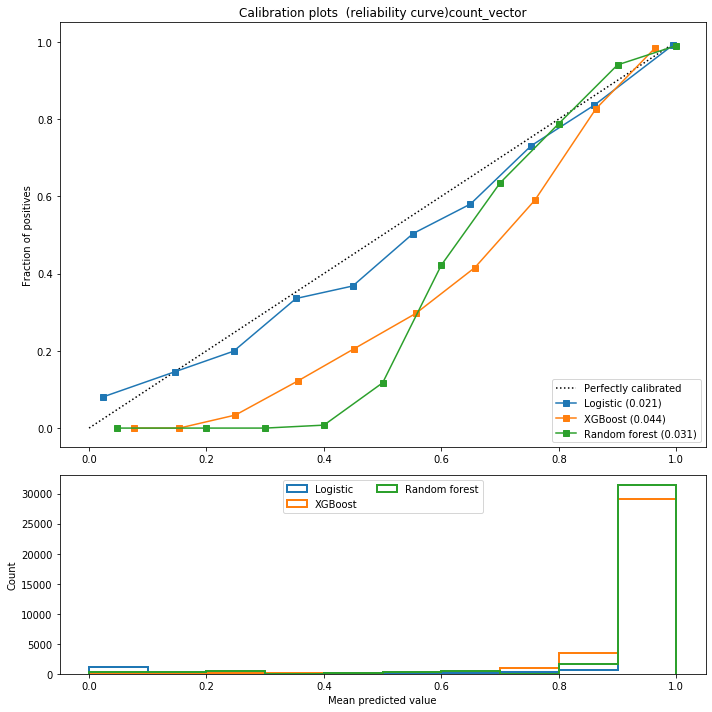

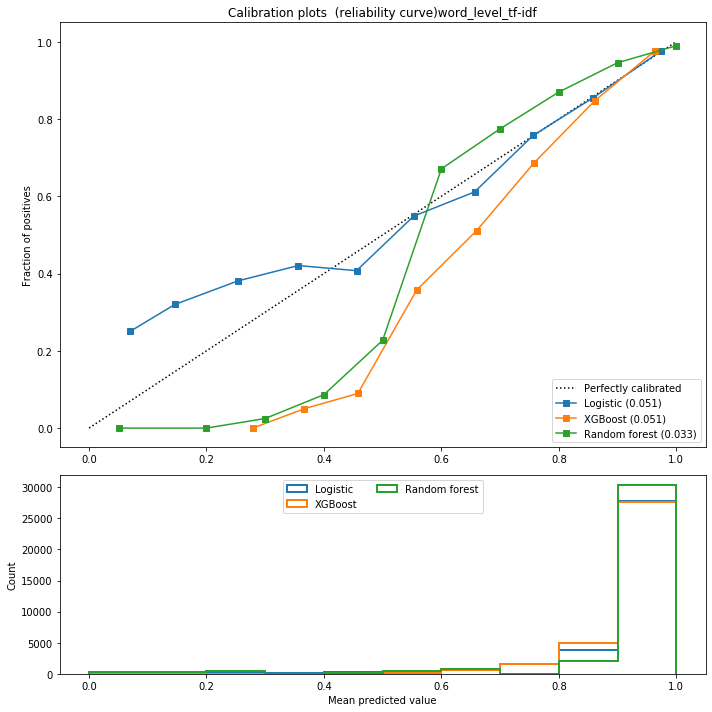

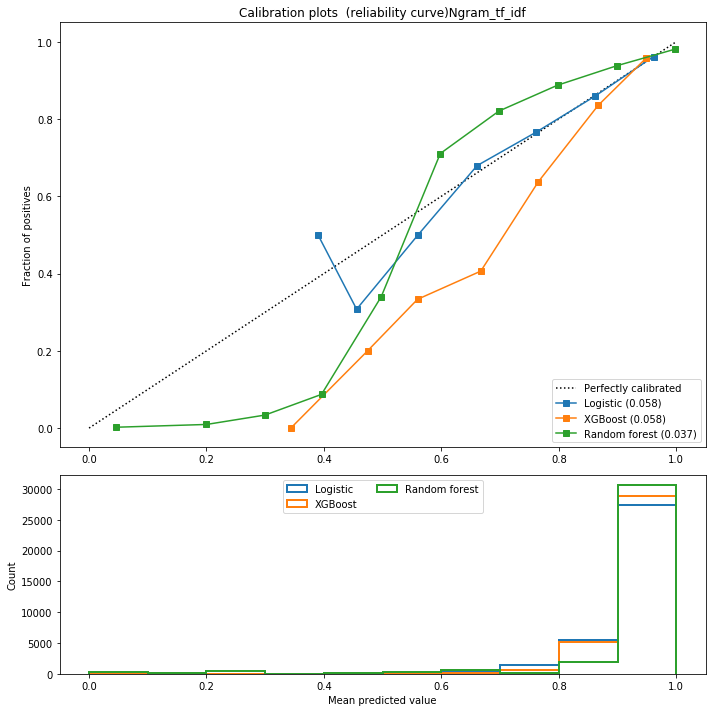

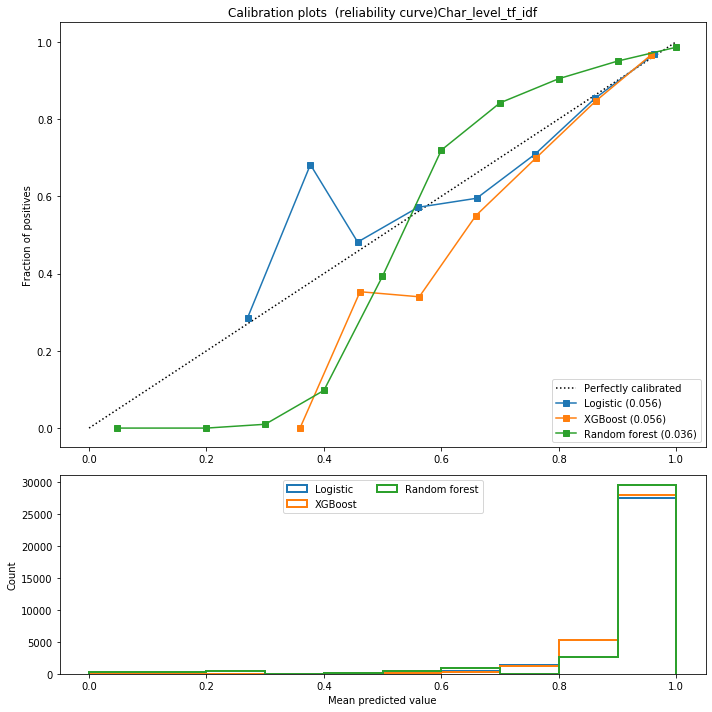

In [0]:
def plot_calibration_curve(xtrain_count, train_y, xvalid_count, fig_index, name):
    """Plot calibration curve for est w/o and with calibration. """
    title = 'Calibration plots  (reliability curve)'+ name
    # multinomial naive bayes model
    nb = xgboost.XGBClassifier()

    # decision tree model
    dt = ensemble.RandomForestClassifier()

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression()

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (nb, 'XGBoost'),
                      (dt, 'Random forest')
                      ]:
        clf.fit(xtrain_count, train_y)
        y_pred = clf.predict(xvalid_count)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(xvalid_count)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(xvalid_count)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = metrics.brier_score_loss(valid_y, prob_pos, pos_label=df['labels'].max())

        fraction_of_positives, mean_predicted_value = calibration.calibration_curve(valid_y, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(title)

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(xtrain_count, train_y, xvalid_count,1,'count_vector')

# Plot calibration curve for Linear SVC
plot_calibration_curve(xtrain_tfidf, train_y, xvalid_tfidf,2,'word_level_tf-idf')

plot_calibration_curve(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram,3,'Ngram_tf_idf')

plot_calibration_curve(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars,4,'Char_level_tf_idf')

plt.show()

# **Bidirectional LSTM with GloVe Embeddings**

In [0]:
texts = df["text"].values
labels = df["labels"].values

In [0]:
MAX_NUM_WORDS=1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))

Found 178932 unique tokens.


In [0]:
VALIDATION_SPLIT=0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [0]:
import os
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
EMBEDDING_DIM = 100 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128); 



Train on 111347 samples, validate on 27836 samples
Epoch 1/10
111347/111347 [==============================] - 405s 4ms/step - loss: 0.1955 - acc: 0.9343 - val_loss: 0.1573 - val_acc: 0.9402
Epoch 2/10
111347/111347 [==============================] - 414s 4ms/step - loss: 0.1407 - acc: 0.9455 - val_loss: 0.1283 - val_acc: 0.9494
Epoch 3/10
111347/111347 [==============================] - 409s 4ms/step - loss: 0.1208 - acc: 0.9523 - val_loss: 0.1207 - val_acc: 0.9532
Epoch 4/10
111347/111347 [==============================] - 407s 4ms/step - loss: 0.1070 - acc: 0.9577 - val_loss: 0.1198 - val_acc: 0.9529
Epoch 5/10
111347/111347 [==============================] - 405s 4ms/step - loss: 0.0960 - acc: 0.9631 - val_loss: 0.1135 - val_acc: 0.9560
Epoch 6/10
111347/111347 [==============================] - 403s 4ms/step - loss: 0.0874 - acc: 0.9666 - val_loss: 0.1134 - val_acc: 0.9588
Epoch 7/10
111347/111347 [==============================] - 398s 4ms/step - loss: 0.0782 - acc: 0.9699 - va

In [0]:
model.save('LSTM_Project.model')

In [0]:
new_model = tf.keras.models.load_model('LSTM_Project.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
new_y = new_model.predict(x_val)
pred_labels = []
for y in new_y:
    pred_labels.append(np.argmax(y))
pred_labels = to_categorical(np.asarray(pred_labels))
y_act = y_val.argmax(1)
y_pred = pred_labels.argmax(1)


In [0]:
accuracy = metrics.accuracy_score(y_pred, y_act)
f1 = metrics.f1_score(y_pred,y_act,labels=np.unique(y_act))
roc_score = metrics.roc_auc_score(y_pred,y_act)
mean_sq_error = metrics.mean_squared_error(y_pred,y_act)
mean_abs_error = metrics.mean_absolute_error(y_pred,y_act)
print("LSTM evaluation")
print ("accuracy:",accuracy,"f1-score:",f1,"roc_score:",roc_score,"mean squared error:",mean_sq_error,"mean absolute error:",mean_abs_error)

LSTM evaluation
accuracy: 0.9858097427791349 f1-score: 0.9923998999480499 roc_score: 0.9603769201134023 mean squared error: 0.014190257220865067 mean absolute error: 0.014190257220865067


# **Classification using BERT**

In [0]:
data = df[['text','labels']]

splitting to train and test set

In [0]:
msk = np.random.rand(len(df)) < 0.8
train_data = data[msk]
test_data = data[~msk]

In [0]:
!pip install pytorch_pretrained_bert
!pip install tools
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from multiprocessing import Pool, cpu_count
from tools import *
import numpy as np
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from torch.utils.data.distributed import DistributedSampler
import logging
from os import listdir
from os.path import isfile, join
import time

logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


#training and testing data according to BERT
train_set = pd.DataFrame({'id':range(len(train_data)),'label':train_data['labels'],'text': train_data['text'].replace(r'\n', ' ', regex=True)})
alpha = []
for i in range(len(train_data)):
  alpha.append('a')

train_set.insert(2,'alpha',alpha,allow_duplicates=True)
test_set = pd.DataFrame({'id':range(len(test_data)),'label':test_data['labels'],'text': test_data['text'].replace(r'\n', ' ', regex=True)})

alpha = []
for i in range(len(test_data)):
  alpha.append('a')

test_set.insert(2,'alpha',alpha,allow_duplicates=True)

train_set.to_csv('train_set.tsv', sep='\t', index=False, header=False)
test_set.to_csv('test_set.tsv', sep='\t', index=False, header=False)

#BERT implementation
from __future__ import absolute_import, division, print_function

import csv
import os
import sys
import logging

csv.field_size_limit(2147483647) # Increase CSV reader's field limit incase we have long text.
logger = logging.getLogger()

class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):

        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class DataProcessor(object):

    def get_train_examples(self, data_dir):
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        raise NotImplementedError()

    def get_labels(self):
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class BinaryClassificationProcessor(DataProcessor):

    def get_train_examples(self, data_dir):

        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train_set.tsv")), "train")

    def get_dev_examples(self, data_dir):

        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test_set.tsv")), "test")

    def get_labels(self):

        return ["0", "1"]

    def _create_examples(self, lines, set_type):

        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

class InputFeatures(object):

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def _truncate_seq_pair(tokens_a, tokens_b, max_length):

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def convert_example_to_feature(example_row):

    example, label_map, max_seq_length, tokenizer, output_mode = example_row

    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_ids = [0] * len(tokens)

    if tokens_b:
        tokens += tokens_b + ["[SEP]"]
        segment_ids += [1] * (len(tokens_b) + 1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    input_mask = [1] * len(input_ids)

    padding = [0] * (max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)

    return InputFeatures(input_ids=input_ids,
                         input_mask=input_mask,
                         segment_ids=segment_ids,
                         label_id=label_id)

inp_dir = "/content/drive/My Drive/CSE_538"

#initial baseline bert model
baseline = 'bert-base-cased'

model_dir = 'model_dir'

out_dir = f'/content/drive/My Drive/CSE_538/{model_dir}/'

res_dir = f'/content/drive/My Drive/CSE_538/{model_dir}_evaluation_report/'

cache = '/content/drive/My Drive/CSE_538/cache/'

#hyperparameters
sequence_length = 128
batch_size = 24
evaluation_batch_size = 32
learn_rate = 2e-5
epochs = 1
seed_val = 42
step_size = 1
initial_prop = 0.1
out_type = 'classification'
config_file = "bert_config.json"
model_file = "pytorch_model.bin"   

if os.path.exists(res_dir) and os.listdir(res_dir):
        res_dir += f'/report_{len(os.listdir(res_dir))}'
        os.makedirs(res_dir)
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
    res_dir += f'/report_{len(os.listdir(res_dir))}'
    os.makedirs(res_dir)

if os.path.exists(out_dir) and os.listdir(out_dir):
        raise ValueError("Please delete existing output directory".format(out_dir))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

classifier = BinaryClassificationProcessor()
training_data = classifier.get_train_examples(inp_dir)
training_data_size = len(training_data)
labels = classifier.get_labels()
num_labels = len(labels)    

train_steps = int(training_data_size / batch_size / step_size) * epochs

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

labelling = {label: i for i, label in enumerate(labels)}
train_examples_for_processing = [(data, labelling, sequence_length, tokenizer, out_type) for data in training_data]

if __name__ ==  '__main__':
    with Pool(cpu_count() - 1) as p:
        train_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=training_data_size))

with open(inp_dir + "train_pickle.pkl", "wb") as f:
    pickle.dump(train_features, f)

model = BertForSequenceClassification.from_pretrained(baseline, cache_dir=cache, num_labels=num_labels)
model.to(device)

tune_parameters = list(model.named_parameters())
decay_lst = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in tune_parameters if not any(i in n for i in decay_lst)], 'weight_decay': 0.01},
    {'params': [p for n, p in tune_parameters if any(i in n for i in decay_lst)], 'weight_decay': 0.0}
    ]

optimizer = BertAdam(optimizer_grouped_parameters,lr=learn_rate,warmup=initial_prop,t_total=train_steps)

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#training
global_step = 0
nb_tr_steps = 0
tr_loss = 0
model.train()
for _ in trange(int(epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
               
        if step_size > 1:
            loss = loss / step_size

        loss.backward()
        print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % step_size == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1


#using fine tuned trained model
model_directory = "/content/drive/My Drive/CSE_538/model_dir/"
model_to_save = model.module if hasattr(model, 'module') else model

output_model_file = os.path.join(model_directory, model_file)
output_config_file = os.path.join(model_directory, config_file)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(model_directory)

if os.path.exists(res_dir) and os.listdir(res_dir):
        res_dir += f'/report_{len(os.listdir(res_dir))}'
        os.makedirs(res_dir)
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
    res_dir += f'/report_{len(os.listdir(res_dir))}'
    os.makedirs(res_dir)

#evaluation function
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    Accuracy = float(tn + tp)/float(tn+tp+fn+fp)
    Precision = float(tp/(tp+fp))
    Recall = float(tp/(tp+fn))
    F1_score = 2*float(Recall * Precision) / float(Recall + Precision)
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "Accuracy": Accuracy,
        "precision": Precision,
        "recall": Recall,
        "f1 score": F1_score
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

tokenizer = BertTokenizer.from_pretrained(model_directory + 'vocab.txt', do_lower_case=False)   

processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(inp_dir)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, sequence_length, tokenizer, out_type) for example in eval_examples]

process_count = cpu_count() - 1
if __name__ ==  '__main__':
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long) 

all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=evaluation_batch_size)

#uses the trained model now
model = BertForSequenceClassification.from_pretrained(model_directory, cache_dir=cache, num_labels=len(label_list))

model.to(device)

eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    loss_fct = CrossEntropyLoss()
    tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    
    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)

result = compute_metrics(model_dir, all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join(res_dir, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache, downloading to /tmp/tmpldhblvmd
100%|██████████| 213450/213450 [00:00<00:00, 390335.63B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpldhblvmd to cache at /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpldhblvmd
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz not found in cache, downloading to /tmp/tmpn3hdw_8m
100%|██████████| 404400730/404400730 [00:35<00:00, 11326637.37B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpn3hdw_8m to cache at /content/drive/My Drive/NLP_project/cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /content/drive/My Drive/NLP_project/cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpn3hdw_8m
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at /content/drive/My Drive/NLP_project/cache/a803ce83ca27

0.022770

Epoch: 100%|██████████| 1/1 [1:29:26<00:00, 5366.30s/it]

0.020970



INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file /content/drive/My Drive/NLP_project/model_dir/vocab.txt


INFO:pytorch_pretrained_bert.modeling:loading archive file /content/drive/My Drive/NLP_project/model_dir/
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}



INFO:root:***** Eval results *****
INFO:root:  task = model_dir
INFO:root:  mcc = 0.7238750620538866
INFO:root:  tp = 25629
INFO:root:  tn = 1282
INFO:root:  fp = 520
INFO:root:  fn = 379
INFO:root:  Accuracy = 0.9676734987414599
INFO:root:  precision = 0.9801139622930131
INFO:root:  recall = 0.9854275607505383
INFO:root:  f1 score = 0.9827635791935886
INFO:root:  eval_loss = 0.08801570441359761


Recommendation generation

In [0]:
#Using LSTM model to get our recommendations
model_name = tf.keras.models.load_model('LSTM_Project.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
t_data = data.sample(frac=1).reset_index(drop=True)
t_data['text'] = t_data['text'].apply(lambda x: x.lower())

train_X = t_data['text']
label_Y = to_categorical(t_data['labels'].values)

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(list(train_X))

test_set_final = tokenizer.texts_to_sequences(train_X)
test_set_final = pad_sequences(test_set_final, maxlen=100)

In [0]:
#predicting labels
total_pred = model_name.predict(test_set_final, batch_size=128, verbose=1)

139183/139183 [==============================] - 84s 602us/sample


In [0]:
upd_lbl = []
for y in total_pred:
    upd_lbl.append(np.argmax(y))
upd_lbl = to_categorical(np.asarray(upd_lbl))
fin_pred = upd_lbl.argmax(1)
actual_lbl = label_Y.argmax(1)

In [0]:
val = {}
for i in range(len(pd.Series.to_list(yelp_reviews['text']))):
  cnt = fin_pred[i]
  cnt = cnt * 2 - 1
  res_name = yelp_reviews['restaurant_id'][i]
  menu_item_name = yelp_reviews['menu_item'][i]
  val.setdefault(res_name, dict())
  val[res_name].setdefault(menu_item_name, 0)
  val[res_name][menu_item_name] += cnt

In [0]:
#top 10 recommended dishes per restaurant stored in result_file.csv
top_rated = {}
f = open('result_file.csv', 'w')
f.write("restaurant,top_rated_dishes\n")
menu_score_pair = []
for i in val:
  menu_score_pair = [(x, y) for x, y in val[i].items()]
  menu_score_pair.sort(key=lambda tup: tup[1], reverse=True)

  tot_rating = 0
  for j in menu_score_pair:
    tot_rating += j[1]
  top_rated[i] = tot_rating
  menu_score_pair = menu_score_pair[:10]
  result = list(map(lambda x: x[0], menu_score_pair))

  f.write("{}, [{}]\n".format(i, " | ".join(result)))
f.close()

fin_dic = [(k, top_rated[k]) for k in sorted(top_rated, key=top_rated.get, reverse=True)]
res_score = {}
rest_names = []
for i in range(10):
  res_score[fin_dic[i][0]] = fin_dic[i][1]

for i in fin_dic:
  rest_names.append(i[0])

In [0]:
#recommendations
r_df = pd.read_csv('result_file.csv')
r_df.head(2)

,restaurant,top_rated_dishes
0,submerge-sandwich-los-angeles,[Pickles | Lemon Herb Chicken Sandwich | BTLA...
1,reggies-deli-and-cafe-los-angeles,[BLT Sandwich | Latte | Potato Salad | Cobb S...


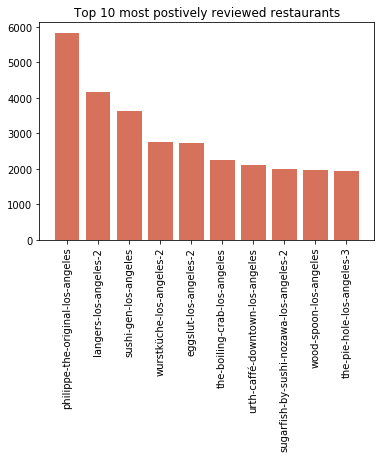

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 


plt.bar(range(len(res_score)), list(res_score.values()), align='center', color=(0.8, 0.3, 0.2, 0.8))
plt.title('Top 10 most postively reviewed restaurants', fontdict=None, loc='center', pad=None)
plt.xticks(range(len(res_score)), list(res_score.keys()), rotation='vertical')

plt.show()

In [0]:
rest_id_name_map = {}
rest_id_name_map = pd.Series(business_data.name.values,index=business_data.id).to_dict()
name_of_restaurant = []
for i in rest_names:
  if i in rest_id_name_map:
    name_of_restaurant.append(rest_id_name_map[i])

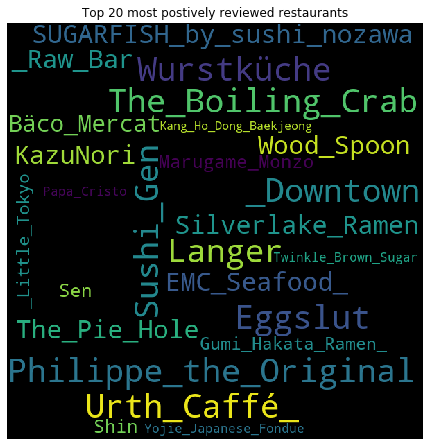

In [0]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
text = ' '
for i in name_of_restaurant[:20]:
  name = i.replace(' ','_')
  text = text + name + ' '

wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black',                
                min_font_size = 10).generate(text) 
                      
plt.figure(figsize = (6, 6), facecolor = None)
plt.title('Top 20 most postively reviewed restaurants', fontdict=None, loc='center', pad=None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()